In [26]:
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import warnings
from math import pi, sin, cos, sqrt, atan2, radians,asin
import os # reading the input files we have access to
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [27]:
train=pd.read_csv("input/train.csv",nrows=1000000)
print("Shape of Training Data",train.shape)
test=pd.read_csv("input/test.csv")
print("Shape of Testing Data", test.shape)

Shape of Training Data (1000000, 8)
Shape of Testing Data (9914, 7)


In [ ]:
train.plot(kind='bar',x='passenger_count',y='fare_amount')
#plt.xlim(left=-1)
#plt.xlim(right = 10)
fig = plt.gcf()
fig.savefig('foo.png')
plt.show()

In [ ]:
fig, ax = plt.subplots()
train['pickup_latitude'].value_counts().plot(ax=ax, kind='bar')
fig.savefig('foo3.png')
plt.show()

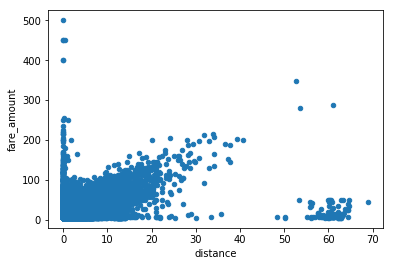

In [38]:
train.plot(kind='scatter',x='distance',y='fare_amount')
fig = plt.gcf()
fig.savefig('foo6.png')
plt.show()

In [61]:
train.loc[:,'fare_amount'].median()

8.5

In [28]:
def clean_data(data):
    boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}
    
    if 'fare_amount' in data.columns: #only for training data
        data=data[data['fare_amount']>=0] #changed to 5 from 0.
        data.loc[~((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
        data.loc[((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

    #print("Outlier vs Non Outlier Counts")
    #print(data['is_outlier_loc'].value_counts())

    # Let us drop rows, where location is outlier
        data=data.loc[data['is_outlier_loc']==0]
        data.drop(['is_outlier_loc'],axis=1,inplace=True)
    
    #Cleaning according to passenger_count
    data = data[data['passenger_count']>0]
    data = data[data['passenger_count']<=8]
    
    return data

In [29]:
train = clean_data(train)
test = clean_data(test)
print("Shape of Training Data after cleaning ",train.shape)
print("Shape of Testing Data after cleaning", test.shape)

/home/s/sidhant/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/s/sidhant/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Shape of Training Data after cleaning  (975317, 8)
Shape of Testing Data after cleaning (9914, 7)


In [30]:
def distance(lat1,lon1,lat2,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
def process_data(data):
    data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
    data['pickup_day']=data['pickup_datetime'].apply(lambda x:x.day)
    #data['pickup_sin_hm'] = data['pickup_datetime'].apply(lambda x:sin(2*pi*(x.hour * 60 + x.minute)/1440))
    #data['pickup_cos_hm'] = data['pickup_datetime'].apply(lambda x:cos(2*pi*(x.hour * 60 + x.minute)/1440))
    data['pickup_hour']=data['pickup_datetime'].apply(lambda x:x.hour)
    data['pickup_month']=data['pickup_datetime'].apply(lambda x:x.month)
    data['pickup_year']=data['pickup_datetime'].apply(lambda x:x.year)
    data['distance'] = data.apply(lambda x: distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
    weekday_names = {0: 'Monday',
                 1: 'Tuesday',
                 2: 'Wednesday',
                 3: 'Thursday',
                 4: 'Friday',
                 5: 'Saturday',
                 6: 'Sunday'}
    data = data.join(pd.get_dummies("is"+data['pickup_datetime'].dt.weekday.apply(lambda x: weekday_names.get(x))))
    #^one-hot encoding of weekday
    #data['pickup_day_of_week']=data['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    #data['pickup_day_of_week'] = data['pickup_day_of_week'].apply(lambda x: encodeDays(x))
    return data

In [31]:
train = process_data(train)
test = process_data(test)
print("Shape of Training Data after cleaning ",train.shape)
print("Shape of Testing Data after cleaning", test.shape)

Shape of Training Data after cleaning  (975317, 20)
Shape of Testing Data after cleaning (9914, 19)


In [7]:
#train = train.drop(['distance'], axis = 1)
#test = test.drop(['distance'], axis = 1)
#train['distance'] = train.apply(lambda x: distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_month,pickup_year,distance,isFriday,isMonday,isSaturday,isSunday,isThursday,isTuesday,isWednesday
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,999990.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924,15.697965,13.509477,6.267875,2011.741106,11.862049,0.154245,0.128678,0.151279,0.131301,0.149670,0.139989,0.144838
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911,8.682461,6.513840,3.436243,1.860754,225.189914,0.361184,0.334843,0.358321,0.337729,0.356748,0.346976,0.351938
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,1.000000,0.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000,8.000000,9.000000,3.000000,2010.000000,0.753687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,16.000000,14.000000,6.000000,2012.000000,1.314773,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000,23.000000,19.000000,9.000000,2013.000000,2.412432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000,31.000000,23.000000,12.000000,2015.000000,10487.691487,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
def splittingData(data,target,drop_cols,is_train=True,split=0.25):
    data_1=data.drop(drop_cols,axis=1)
    if is_train == True:
        X = data_1.drop([target],axis=1)
        y = data_1[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split,random_state=123)
        
        print("Shape of Training Features",X_train.shape)
        print("Shape of Validation Features ",X_test.shape)
        
        return X_train, X_test, y_train, y_test
    else:
        print ("Shape of Test Data",data_1.shape)
        return data_1

In [33]:
X_train, X_test, y_train, y_test = splittingData(train,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=True,split=0.2)

Shape of Training Features (780253, 17)
Shape of Validation Features  (195064, 17)


In [34]:
test_data=splittingData(test,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=False)

Shape of Test Data (9914, 17)


In [22]:
# test_data is ready

In [35]:
avg_fare=round(np.mean(y_train),2)
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Basline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 9.76926259606828


In [36]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=np.round(lm.predict(X_test),2)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  5.571506295670732


In [37]:
rf = RandomForestRegressor(n_estimators = 96, random_state = 1,n_jobs=-1, verbose=2)
rf.fit(X_train,y_train)
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)
print(rf.feature_importances_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 96
building tree 2 of 96
building tree 3 of 96
building tree 4 of 96
building tree 5 of 96
building tree 6 of 96
building tree 7 of 96building tree 8 of 96
building tree 9 of 96
building tree 10 of 96
building tree 11 of 96building tree 12 of 96
building tree 13 of 96
building tree 14 of 96
building tree 15 of 96
building tree 16 of 96
building tree 17 of 96

building tree 18 of 96building tree 19 of 96building tree 20 of 96
building tree 21 of 96building tree 22 of 96



building tree 23 of 96
building tree 24 of 96

building tree 25 of 96
building tree 26 of 96
building tree 27 of 96
building tree 28 of 96
building tree 29 of 96
building tree 30 of 96
building tree 31 of 96
building tree 32 of 96
building tree 33 of 96
building tree 34 of 96
building tree 35 of 96
building tree 36 of 96
building tree 37 of 96
building tree 38 of 96
building tree 39 of 96
building tree 40 of 96
building tree 41 of 96
building tree 42 of 96
building tree 43 of 96
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.5min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  96 out of  96 | elapsed:    2.7s finished


RMSE for Random Forest is  4.261431262399582
[0.03450307 0.02424966 0.05326596 0.0331109  0.00360799 0.01213788
 0.01441362 0.01042521 0.02623616 0.77668607 0.00166991 0.00157591
 0.00161581 0.00170979 0.00183735 0.00139661 0.0015581 ]


In [25]:
def pltRmse(n):
    rf = RandomForestRegressor(n_estimators = n, random_state = 1,n_jobs=-1, verbose=2)
    rf.fit(X_train,y_train)
    rf_pred= rf.predict(X_test)
    rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
    print(n)
    print("RMSE for Random Forest is ",rf_rmse)
    return rf_rmse
    #print(rf.feature_importances_)
A = [1, 2, 3, 4, 5, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160]
B = list(map(lambda x : pltRmse(x), A))
print(A)
print(B)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 1


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


1
RMSE for Random Forest is  5.7349462346385005
building tree 1 of 2building tree 2 of 2



[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished


2
RMSE for Random Forest is  4.986006009975798
building tree 1 of 3building tree 2 of 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 3 of 3


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished


3
RMSE for Random Forest is  4.804936495189424
building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   22.5s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   23.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


4
RMSE for Random Forest is  4.665503252707804
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.3s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.3s finished


5
RMSE for Random Forest is  4.578362720469016
building tree 1 of 6building tree 2 of 6
building tree 3 of 6

building tree 4 of 6
building tree 5 of 6
building tree 6 of 6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   23.0s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   24.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.3s finished


6
RMSE for Random Forest is  4.512410285354388
building tree 1 of 10
building tree 2 of 10building tree 3 of 10
building tree 4 of 10
building tree 5 of 10

building tree 6 of 10
building tree 7 of 10building tree 8 of 10
building tree 9 of 10

building tree 10 of 10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   27.8s remaining:   27.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.4s finished


10
RMSE for Random Forest is  4.411781168641206
building tree 1 of 20building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20building tree 9 of 20building tree 10 of 20
building tree 11 of 20

building tree 12 of 20
building tree 13 of 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20




[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:   40.2s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   41.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   44.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    0.5s remaining:    2.6s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.7s finished


20
RMSE for Random Forest is  4.324740639477923


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 30building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30

building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30building tree 21 of 30
building tree 22 of 30

building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   44.8s remaining:   44.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  15 out of  30 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  30 out of  30 | elapsed:    0.9s finished


30
RMSE for Random Forest is  4.297769651798492


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40building tree 10 of 40
building tree 11 of 40

building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   39.2s


building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:   45.2s remaining:  1.4min


building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  2.6min remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.7min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    1.3s finished


40
RMSE for Random Forest is  4.283521659305085


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50building tree 24 of 50

building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:  2.5min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  29 out of  50 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=24)]: Done  50 out of  50 | elapsed:    1.6s finished


50
RMSE for Random Forest is  4.275664817414739


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60building tree 12 of 60
building tree 13 of 60

building tree 14 of 60building tree 15 of 60
building tree 16 of 60building tree 17 of 60

building tree 18 of 60
building tree 19 of 60
building tree 20 of 60

building tree 21 of 60
building tree 22 of 60
building tree 23 of 60building tree 24 of 60

building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:  2.1min remaining:   45.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  44 out of  60 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=24)]: Done  60 out of  60 | elapsed:    1.7s finished


60
RMSE for Random Forest is  4.272412848803342


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 70building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70building tree 6 of 70
building tree 7 of 70

building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70

building tree 24 of 70

building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70building tree 30 of 70
building tree 31 of 70

building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70building tree 40 of 70

building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  59 out of  70 | elapsed:  2.1min remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.2min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  59 out of  70 | elapsed:    1.9s remaining:    0.4s
[Parallel(n_jobs=24)]: Done  70 out of  70 | elapsed:    2.1s finished


70
RMSE for Random Forest is  4.267657461654715


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 80building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80

building tree 25 of 80
building tree 26 of 80
building tree 27 of 80building tree 28 of 80

building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:  2.6min remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  74 out of  80 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    2.2s finished


80
RMSE for Random Forest is  4.267001368258731


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 90building tree 2 of 90building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90


building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90building tree 22 of 90

building tree 23 of 90
building tree 24 of 90


KeyboardInterrupt: 